# Capstone Project - The Battle of the Neighbourhoods

### Applied Data Science Capstone by Hueyling Lim

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Penang’s colonial history and architecture are second to none, and its 2008 UNESCO heritage listing really put its capital, George Town, on the map.In recent years, Malaysia has developed a café culture that rivals the likes of New York, London, Paris, and Prague. Penang takes its coffee seriously.

In this project we will list and visualize all major parts of Penang that has great Cafes. Specifically, this report will be targeted to stakeholders interested in opening a Cafe in Penang, Malaysia. 

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.


## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:

* find all existing Cafes in the neighborhood
* find rating , tips and like count for each Cafes
* visualize the ranking of neighborhoods

Following data sources will be needed to extract/generate the required information:

* using FourSquare API we will find all venues for each neighborhood
* filter out all venues that are Cafes
* find rating , tips and like count for each Cafes using FourSquare API
* using rating for each Cafe, we will sort that data.
* visualize the Ranking of neighborhoods using folium library(python)

### * Required Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim
import os
import requests
import sys
from pandas.io.json import json_normalize 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
!pip install folium
import folium
print('Libraries imported.')

     |████████████████████████████████| 93 kB 3.9 MB/s  eta 0:00:01
Libraries imported.


### * Neighborhood Candidates

Define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="penang_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Define a function to intract with FourSquare API and get top 100 venues within a radius of 500 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [9]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'SQBCCQR0UHCWDSP4ZJWIVKU0VLE15QLIAAQJB2YCV0TBV3FF'
    CLIENT_SECRET = 'CB3SUADTYQ0DXFGFKEZVCWTFWYJP5KRF0AOGJKZOYM00N4UA'
    VERSION = '20201218'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    
    return df

Define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'WD2O0PAUKY3MWF5NLZQAOIY55F0O1KGDXISP5CUXTEGH4QDD'
    CLIENT_SECRET = 'NH4XRHOI0XCRLNMBSW2QZI1BROJ24HJDQNE1ITLKFG2SKGN0'
    VERSION = '20201218'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Call the funtion to get the penang data.

In [5]:
url="https://raw.githubusercontent.com/Hueyling-lim/Coursera/main/Penang%20dataset%20(updated).csv"
penang_data=pd.read_csv(url)
penang_data.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Batu Ferringhi,Teluk Bahang,5.463410,100.234356
1,Batu Ferringhi,Feringgi Villas,5.469894,100.240332
2,Batu Ferringhi,Kampung Batu Feringgi,5.469825,100.245169
3,Batu Ferringhi,Kampung Tanjung Huma,5.477872,100.252977
4,Batu Ferringhi,Kawasan Perumahan Sungai Emas,5.474411,100.255349


In [6]:
penang_data.shape

(203, 4)

There are total of 203 different Neighborhoods in Penang, Malaysia.

Collect cafes for each Neighbourhood.

In [10]:
# prepare neighborhood list that contains cafes
column_names=['Borough', 'Neighbourhood', 'ID','Name']
cafe_pen=pd.DataFrame(columns=column_names)

for row in penang_data.values.tolist():
    Borough, Neighbourhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    cafe=venues[venues['Category']=='Café']   
    
    for cafe_detail in cafe.values.tolist():
        id, name , category=cafe_detail
        cafe_pen = cafe_pen.append({'Borough': Borough,
                                    'Neighbourhood': Neighbourhood, 
                                    'ID': id,
                                    'Name' : name
                                    }, ignore_index=True)

In [11]:
cafe_pen.head()

,Borough,Neighbourhood,ID,Name
0,Batu Ferringhi,Teluk Bahang,4cc3ef2f82388cfa58ba6b35,Tree Monkey Restaurant
1,Batu Ferringhi,Teluk Bahang,5125e6b3e4b07738276d44d9,Warung Mkn Dpn Tropical Spice Garden
2,Batu Ferringhi,Teluk Bahang,56473a85498efd91fce72286,Pak Mid Cafe
3,Batu Ferringhi,Feringgi Villas,4f7e8e740cd67eb9fc1cc630,Ferringhi Coffee Garden
4,Batu Ferringhi,Feringgi Villas,4d4eaed0e0f2a1cd65a38f8d,Living Room Bistro & Cafe


In [12]:
cafe_pen.shape

(679, 4)

Delete duplicate cafe.

In [13]:
# dropping ALL duplicte values 
cafe_pen1=cafe_pen.drop_duplicates(subset ="Name", keep = "first", inplace = False) 
  
# displaying data 
cafe_pen1.head()

,Borough,Neighbourhood,ID,Name
0,Batu Ferringhi,Teluk Bahang,4cc3ef2f82388cfa58ba6b35,Tree Monkey Restaurant
1,Batu Ferringhi,Teluk Bahang,5125e6b3e4b07738276d44d9,Warung Mkn Dpn Tropical Spice Garden
2,Batu Ferringhi,Teluk Bahang,56473a85498efd91fce72286,Pak Mid Cafe
3,Batu Ferringhi,Feringgi Villas,4f7e8e740cd67eb9fc1cc630,Ferringhi Coffee Garden
4,Batu Ferringhi,Feringgi Villas,4d4eaed0e0f2a1cd65a38f8d,Living Room Bistro & Cafe


In [14]:
cafe_pen1.shape

(160, 4)

There are 160 Cafes in Penang.

Now we will get the ranking of each resturant for further analysis.

In [19]:
column_names=['Borough', 'Neighbourhood', 'ID','Name','Likes','Rating','Tips']
cafe_stats_pen=pd.DataFrame(columns=column_names)
count=1


for row in cafe_pen1.values.tolist():
    Borough,Neighbourhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(cafe_pen1),')','processed')
    cafe_stats_pen = cafe_stats_pen.append({'Borough': Borough,
                                            'Neighbourhood': Neighbourhood, 
                                            'ID': id,
                                            'Name' : name,
                                            'Likes' : likes,
                                            'Rating' : rating,
                                            'Tips' : tips
                                            }, ignore_index=True)
    count+=1

                         ID                    Name  Likes  Rating  Tips
0  4cc3ef2f82388cfa58ba6b35  Tree Monkey Restaurant    152     7.6    75
( 1 / 160 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 5125e6b3e4b07738276d44d9
( 2 / 160 ) processed
                         ID          Name  Likes  Rating  Tips
0  56473a85498efd91fce72286  Pak Mid Cafe     13     5.6    11
( 3 / 160 ) processed
                         ID                     Name  Likes  Rating  Tips
0  4f7e8e740cd67eb9fc1cc630  Ferringhi Coffee Garden    148     8.5    77
( 4 / 160 ) processed
                         ID                       Name  Likes  Rating  Tips
0  4d4eaed0e0f2a1cd65a38f8d  Living Room Bistro & Cafe     20     7.2    23
( 5 / 160 ) processed
                         ID           Name  Likes  Rating  Tips
0  50e07bb8e4b0bc86ae6424bc  I Love U Cafe     21     5.6    14
( 6 / 160 ) processed
                         ID         Name  Likes  R

KeyError: 'venue'

In [20]:
cafe_stats_pen.head()

,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips
0,Batu Ferringhi,Teluk Bahang,4cc3ef2f82388cfa58ba6b35,Tree Monkey Restaurant,152,7.6,75
1,Batu Ferringhi,Teluk Bahang,0,0,0,0.0,0
2,Batu Ferringhi,Teluk Bahang,56473a85498efd91fce72286,Pak Mid Cafe,13,5.6,11
3,Batu Ferringhi,Feringgi Villas,4f7e8e740cd67eb9fc1cc630,Ferringhi Coffee Garden,148,8.5,77
4,Batu Ferringhi,Feringgi Villas,4d4eaed0e0f2a1cd65a38f8d,Living Room Bistro & Cafe,20,7.2,23


In [21]:
cafe_stats_pen1 = cafe_stats_pen[cafe_stats_pen['Name'] != 0]
cafe_stats_pen1.head()

,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips
0,Batu Ferringhi,Teluk Bahang,4cc3ef2f82388cfa58ba6b35,Tree Monkey Restaurant,152,7.6,75
2,Batu Ferringhi,Teluk Bahang,56473a85498efd91fce72286,Pak Mid Cafe,13,5.6,11
3,Batu Ferringhi,Feringgi Villas,4f7e8e740cd67eb9fc1cc630,Ferringhi Coffee Garden,148,8.5,77
4,Batu Ferringhi,Feringgi Villas,4d4eaed0e0f2a1cd65a38f8d,Living Room Bistro & Cafe,20,7.2,23
5,Batu Ferringhi,Kampung Batu Feringgi,50e07bb8e4b0bc86ae6424bc,I Love U Cafe,21,5.6,14


In [22]:
cafe_stats_pen1.shape

(43, 7)

In [23]:
cafe_stats_pen1.to_csv('cafe_stats_pen1.csv', index=False)

In [24]:
cafe_stats_pen1_csv=pd.read_csv('cafe_stats_pen1.csv')

In [25]:
cafe_stats_pen1_csv.shape

(43, 7)

In [26]:
cafe_stats_pen1_csv.head()

,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips
0,Batu Ferringhi,Teluk Bahang,4cc3ef2f82388cfa58ba6b35,Tree Monkey Restaurant,152,7.6,75
1,Batu Ferringhi,Teluk Bahang,56473a85498efd91fce72286,Pak Mid Cafe,13,5.6,11
2,Batu Ferringhi,Feringgi Villas,4f7e8e740cd67eb9fc1cc630,Ferringhi Coffee Garden,148,8.5,77
3,Batu Ferringhi,Feringgi Villas,4d4eaed0e0f2a1cd65a38f8d,Living Room Bistro & Cafe,20,7.2,23
4,Batu Ferringhi,Kampung Batu Feringgi,50e07bb8e4b0bc86ae6424bc,I Love U Cafe,21,5.6,14


In [27]:
cafe_stats_pen1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43 entries, 0 to 49
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Borough        43 non-null     object 
 1   Neighbourhood  43 non-null     object 
 2   ID             43 non-null     object 
 3   Name           43 non-null     object 
 4   Likes          43 non-null     object 
 5   Rating         43 non-null     float64
 6   Tips           43 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.7+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis.

In [29]:
cafe_stats_pen1_csv['Likes']=cafe_stats_pen1_csv['Likes'].astype('float64')

In [30]:
cafe_stats_pen1_csv['Tips']=cafe_stats_pen1_csv['Tips'].astype('float64')

In [31]:
cafe_stats_pen1_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Borough        43 non-null     object 
 1   Neighbourhood  43 non-null     object 
 2   ID             43 non-null     object 
 3   Name           43 non-null     object 
 4   Likes          43 non-null     float64
 5   Rating         43 non-null     float64
 6   Tips           43 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.5+ KB


## Methodology <a name="methodology"></a>

In this project we will list and visualize all major parts of Penang that has great Cafes. We will limit our analysis to major part area around city center George Town.

In first step we have collected the required data (location) and also identified Cafes around city center according to Foursquare categorization.

Second step in our analysis will be calculation and exploration of 'ranking' (rating , tips and like) of each Cafe by using FourSquare API and focus our attention on those areas.

In final step we will present map of the Neighbourhoods around city center with top average Rating which should be a starting point for final exploration and search for optimal venue location by stakeholders.

## Analysis <a name="analysis"></a>

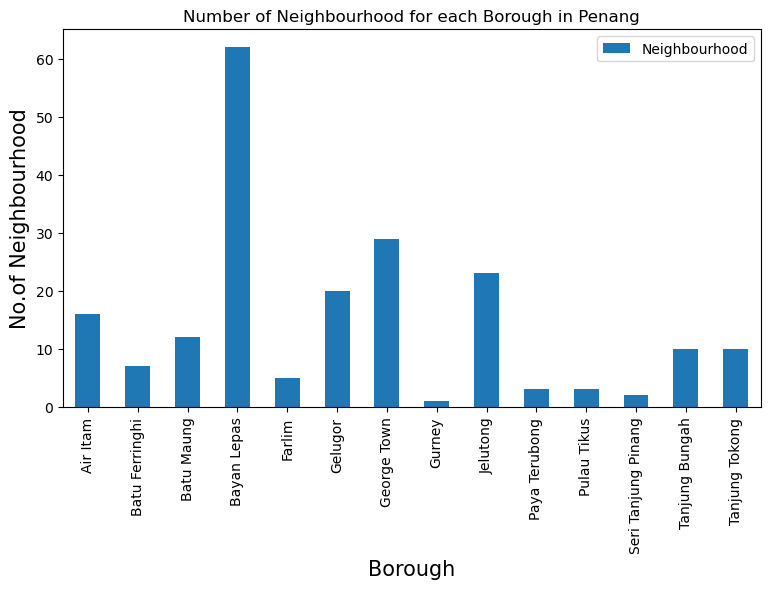

In [7]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighbourhood for each Borough in Penang')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighbourhood', fontsize=15)
#giving a bar plot
penang_data.groupby('Borough')['Neighbourhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Bayan Lepas has highest number of neighborhoods.

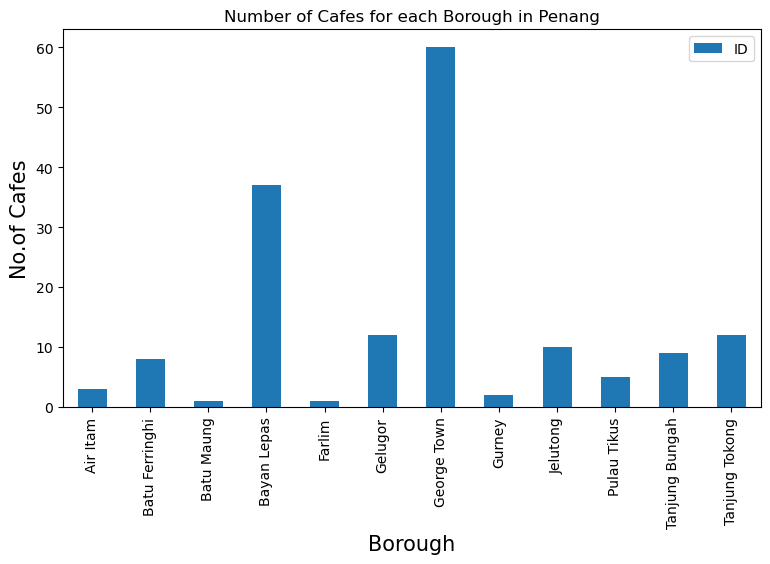

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Cafes for each Borough in Penang')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Cafes', fontsize=15)
#giving a bar plot
cafe_pen1.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

George Town has the largest number of Cafes.

In [18]:
cafe_pen1[cafe_pen1['Borough']=='George Town']

,Borough,Neighbourhood,ID,Name
104,George Town,Kampung Syed,5800d37338faf61a75650a05,Winn's Cafe
105,George Town,Kampung Syed,51e618d5498ecebf9b23ccad,Harvest Times
106,George Town,Kampung Syed,5297f6ba498e3d6cd7d2a0ce,Patois Cafe & Bistro
108,George Town,Kampung Syed,5779ee97498e9a0812c222aa,Little Street Cafe
110,George Town,Jalan Macalister,52f9eb80498ecfcd89440de7,Coffee Journey
111,George Town,Jalan Macalister,504855e1e4b0a1f972c55720,Uhs Canteen
114,George Town,Peel Hwy,51b6bee0498e1471f137aab9,Living Room
117,George Town,Peel Hwy,56a5cfd9498e4c87a3df38f0,Creameal
120,George Town,Peel Hwy,588ea5544f1069046a741397,G2 house of coffee and tea
125,George Town,Jalan Utama,564d87ee498e42f3136551d2,Macalister Corner


So George Town has the highest number of Cafes with a total count of 60.

In [68]:
# Cafe with maximum Likes
cafe_stats_pen1_csv.iloc[cafe_stats_pen1_csv['Likes'].idxmax()]

Borough                       George Town
Neighbourhood                 Jalan Perak
ID               4e2ae369aeb745b1fabcf8c0
Name                               PIKNIK
Likes                                 519
Rating                                  8
Tips                                  251
Name: 39, dtype: object

In [41]:
# Cafe with maximum Rating
cafe_stats_pen1_csv.iloc[cafe_stats_pen1_csv['Rating'].idxmax()]

Borough                    Tanjung Tokong
Neighbourhood               Pepper Estate
ID               59f4a11ee2d4aa7257b13d41
Name                        Meraki Coffee
Likes                                  22
Rating                                8.7
Tips                                   10
Name: 17, dtype: object

In [42]:
# Cafe with maximum Tips
cafe_stats_pen1_csv.iloc[cafe_stats_pen1_csv['Tips'].idxmax()]

Borough                       George Town
Neighbourhood                 Jalan Perak
ID               4e2ae369aeb745b1fabcf8c0
Name                               PIKNIK
Likes                                 519
Rating                                  8
Tips                                  251
Name: 39, dtype: object

In [43]:
pen_neighbourhood_stats=cafe_stats_pen1_csv.groupby('Neighbourhood',as_index=False).mean()[['Neighbourhood','Rating']]
pen_neighbourhood_stats.columns=['Neighbourhood','Average Rating']

In [44]:
pen_neighbourhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighbourhood,Average Rating
17,Pepper Estate,8.700000
2,Feringgi Villas,7.850000
6,Jalan Perak,7.600000
21,Tanjung Tokong,7.533333
13,Kampung Syed,7.475000
0,Crystal Garden,7.400000
7,Jalan Sultan Ahmad Shah,7.250000
16,Peel Hwy,7.100000
11,Kampung Belachan,6.800000
12,Kampung Masjid,6.600000


Above are the top neighbourhoods with top average rating of Cafes.

In [45]:
pen_borough_stats=cafe_stats_pen1_csv.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
pen_borough_stats.columns=['Borough','Average Rating']

In [46]:
pen_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,George Town,7.133333
5,Tanjung Tokong,7.081818
0,Batu Ferringhi,6.728571
2,Gurney,6.500000
3,Pulau Tikus,6.280000


Similarly these are the average rating of Cafes for each Borough.

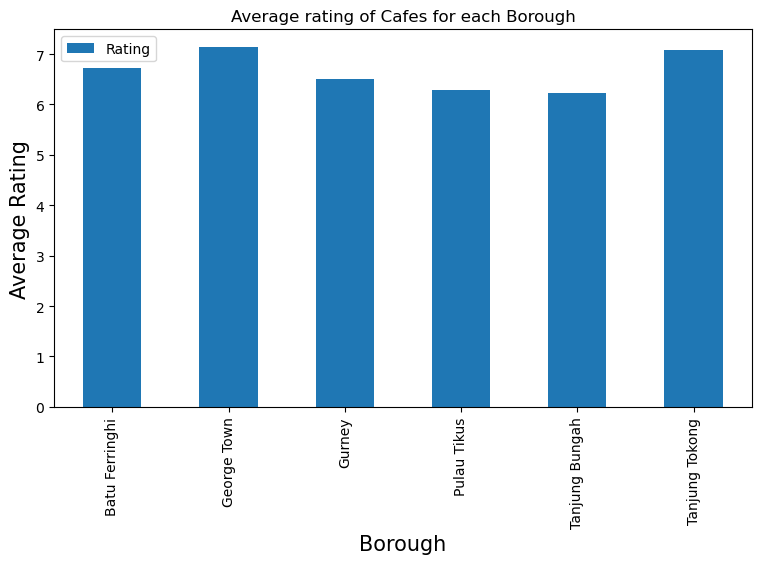

In [39]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Cafes for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
cafe_stats_pen1_csv.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 7.0 to visualize on map.

In [51]:
pen_neighbourhood_stats=pen_neighbourhood_stats[pen_neighbourhood_stats['Average Rating']>=7.0]
pen_neighbourhood_stats

,Neighbourhood,Average Rating
0,Crystal Garden,7.400000
2,Feringgi Villas,7.850000
6,Jalan Perak,7.600000
7,Jalan Sultan Ahmad Shah,7.250000
13,Kampung Syed,7.475000
16,Peel Hwy,7.100000
17,Pepper Estate,8.700000
21,Tanjung Tokong,7.533333


We will join this dataset to original penang data to get lonitude and latitude.

In [52]:
pen_neighbourhood_stats=pd.merge(pen_neighbourhood_stats,penang_data, on='Neighbourhood')

In [53]:
pen_neighbourhood_stats=pen_neighbourhood_stats[['Borough','Neighbourhood','Latitude','Longitude','Average Rating']]

In [54]:
pen_neighbourhood_stats

,Borough,Neighbourhood,Latitude,Longitude,Average Rating
0,Tanjung Tokong,Crystal Garden,5.439289,100.304181,7.400000
1,Batu Ferringhi,Feringgi Villas,5.469894,100.240332,7.850000
2,George Town,Jalan Perak,5.421840,100.317483,7.600000
3,George Town,Jalan Sultan Ahmad Shah,5.426050,100.323507,7.250000
4,George Town,Kampung Syed,5.429132,100.317125,7.475000
5,George Town,Peel Hwy,5.423741,100.315437,7.100000
6,Tanjung Tokong,Pepper Estate,5.455214,100.298222,8.700000
7,Tanjung Tokong,Tanjung Tokong,5.459007,100.303412,7.533333


Now we will show this data on a map.

In [57]:
# create map and display it
pen_map = folium.Map(location=geo_location('Penang'), zoom_start=12)

In [58]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in pen_neighbourhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose.

In [59]:
pen_neighbourhood_stats['Label']=pen_neighbourhood_stats['Neighbourhood']+', '+pen_neighbourhood_stats['Borough']+'('+pen_neighbourhood_stats['Average Rating'].map(str)+')'

Now that we have visualized the Neighborhoods based on average Rating.

In [60]:
# add pop-up text to each marker on the map
for lat, lng, label in pen_neighbourhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(pen_map)        
# add incidents to map
pen_map.add_child(incidents)

## Results and Discussion <a name="results"></a>

Our analysis shows that there is 160 Cafes in major parts of Penang around city center George Town. Although the borough "Bayan Lepas" has highest number of neighbourhoods but the borough "George Town" has the highest number of Cafes with a total count of 60 (around 40%). By using Foursquare API, we found that the Cafe "PIKNIK" at George Town has maximum likes and tips and the Cafe "Pepper Estate" at Tanjung Tokong has maximum rating. Result of the Foursquare Ranking, we found that the boroughs with top 3 of average rating greater or equal 7.0 which are George Town, Tanjung Tokong and Batu Ferringhi. 

## Conclusion <a name="conclusion"></a>

Purpose of this project was to list and visualize all major parts of Penang that has great Cafes in order to aid stakeholders in narrowing down the search for optimal location for a new Cafe. By analysis ranking from Foursquare data we have first identified general boroughs that justify further analysis, and then generated extensive collection of locations which satisfy some basic requirements regarding existing nearby Cafes.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.